In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import mode
from ipywidgets import widgets
from scipy.stats import ttest_ind
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro
import seaborn as sns
import statsmodels.api as sm
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_billet = pd.read_csv('billets.csv', sep=";")

In [4]:
df_billet.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


# Vue globale des données

In [9]:
print(df_billet.shape)
df_billet.info()

(1500, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [11]:
df_billet.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

- Nous avons constater quelques valeurs manquantes au niveau du margin_low que nous allons imputer en bas

# Analyse des variables numériques
### Les caractéristiques des billets selon qu'ils soient vrais ou faux
#### Visualisation des variables

Observons la relation entre les variables 2 par 2.

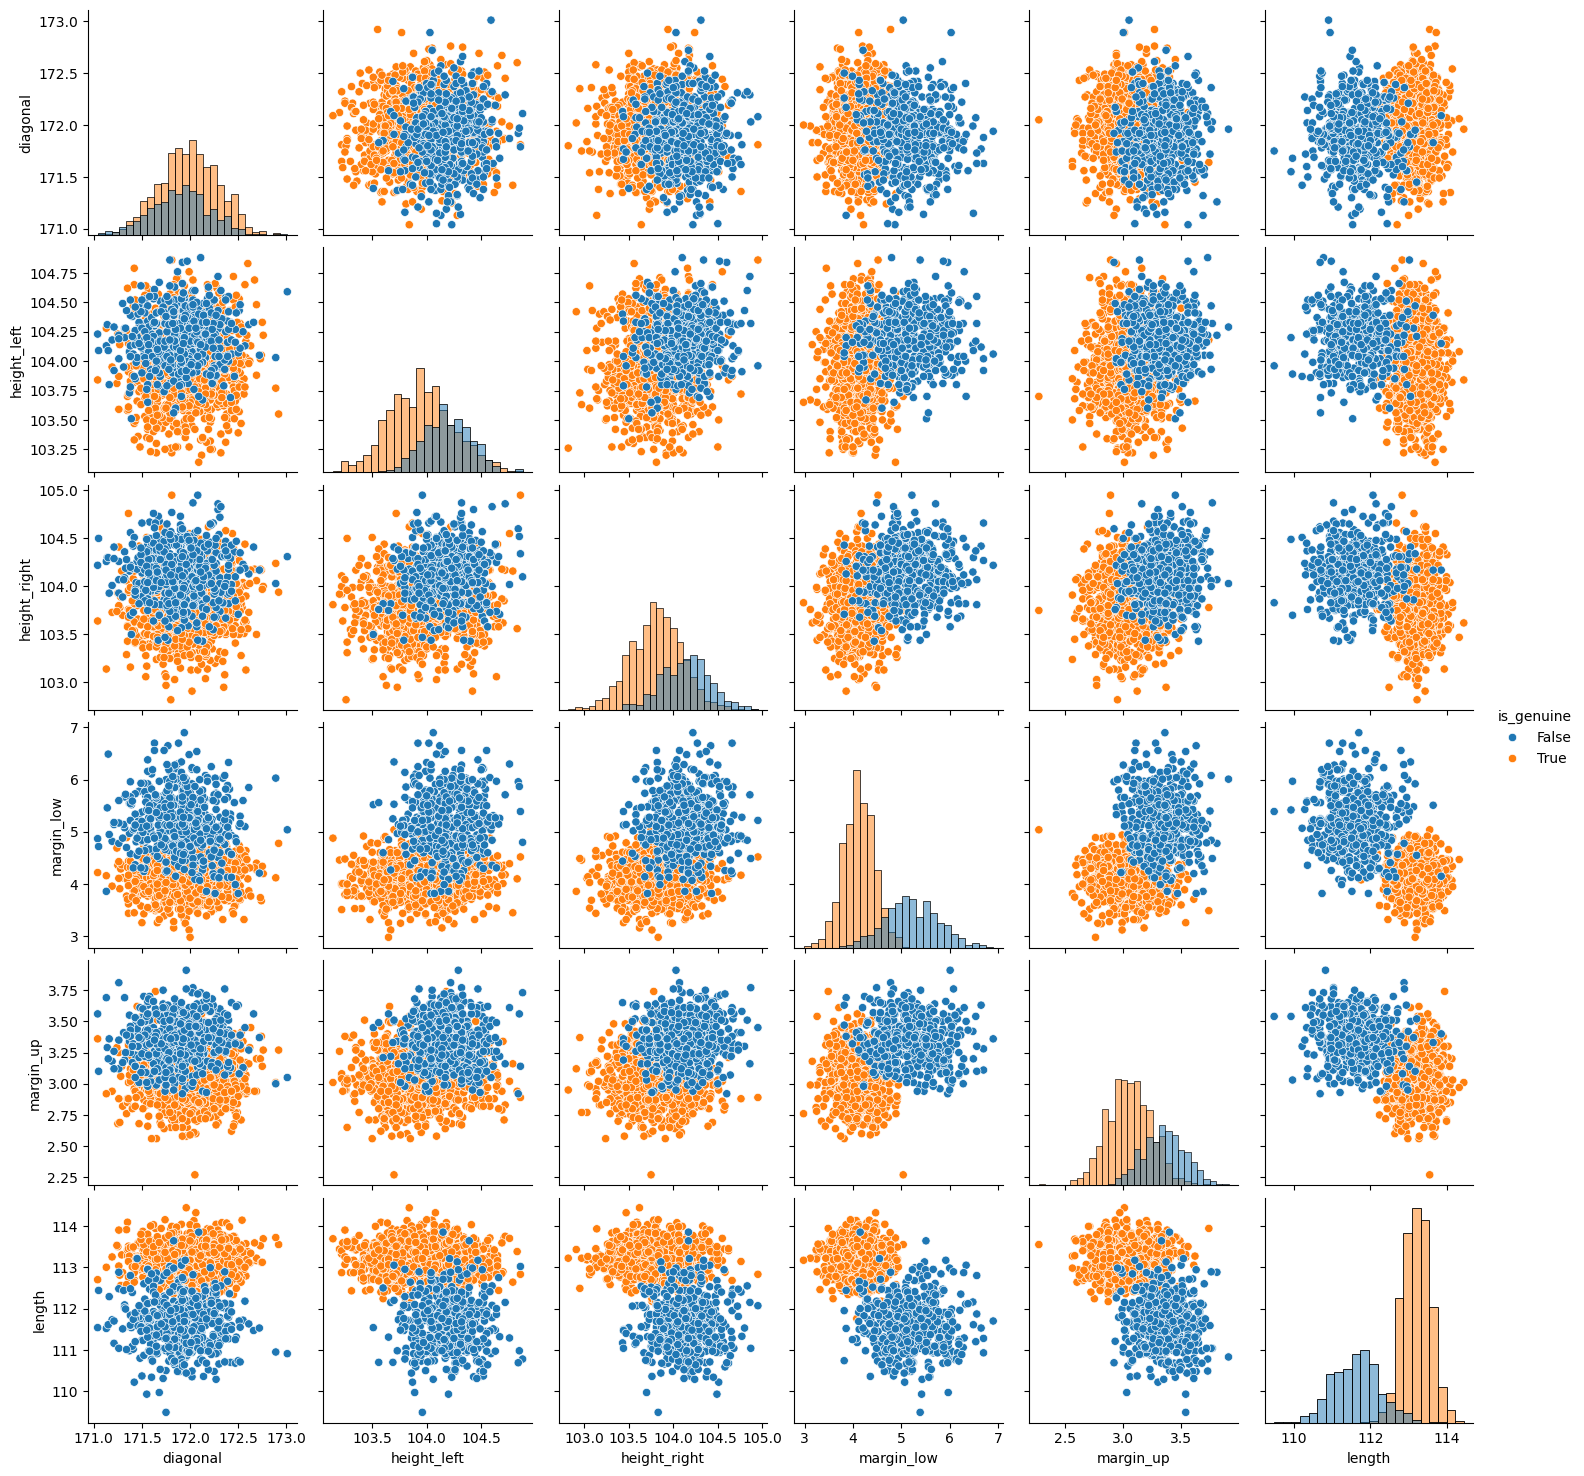

In [14]:
sns.pairplot(data=df_billet, hue='is_genuine', diag_kind='hist')
plt.show()

In [15]:
billet_vrai = df_billet[df_billet['is_genuine'] == True]
billet_faux = df_billet[df_billet['is_genuine'] == False]

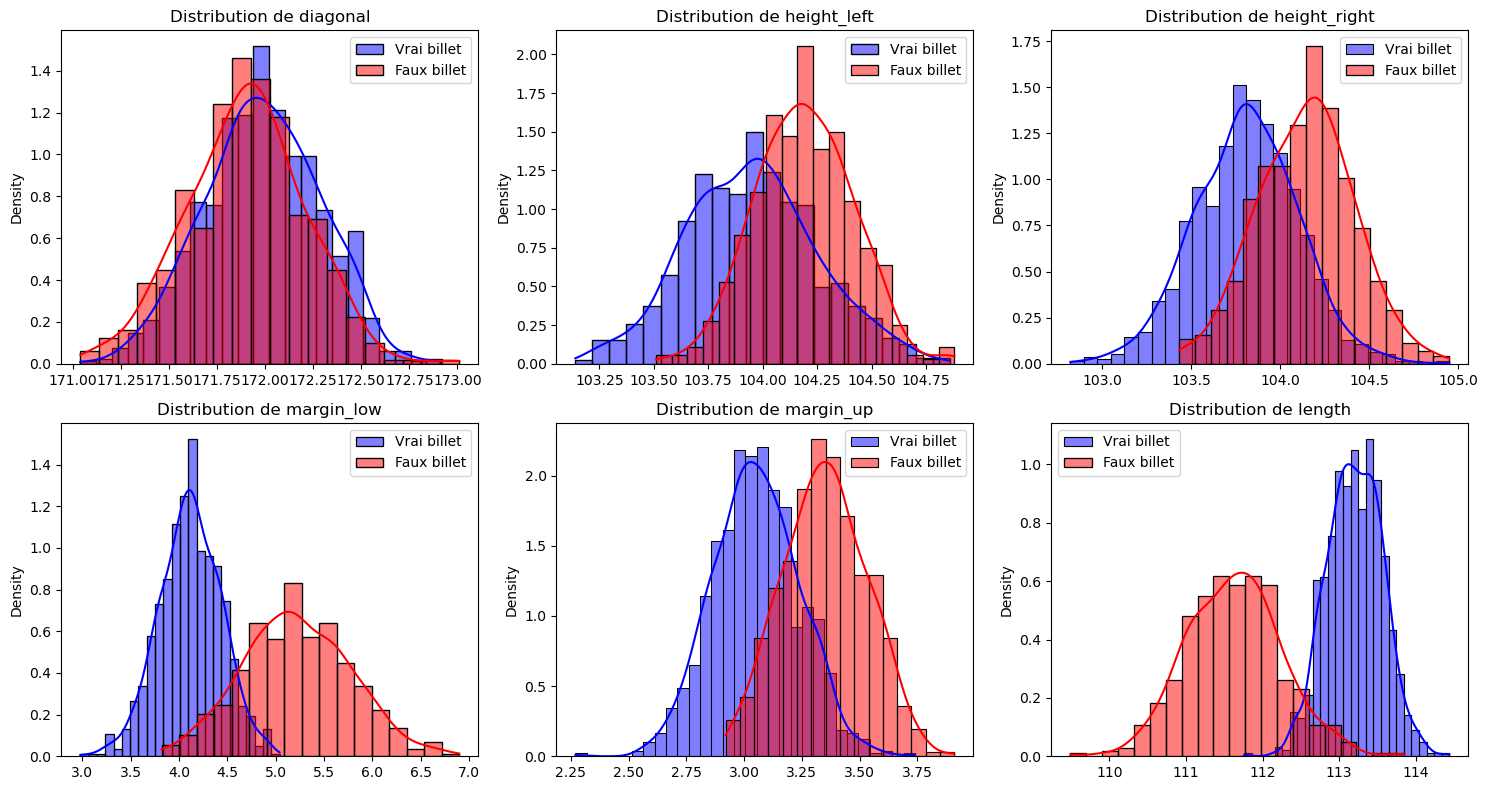

In [16]:
colonnes = df_billet.columns[1:]
n = len(colonnes)
ncols = 3
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

for i, col in enumerate(colonnes):
    sns.histplot(billet_vrai[col], label="Vrai billet", ax=axes[i], kde=True, stat="density", color="blue", alpha=0.5)
    sns.histplot(billet_faux[col], label="Faux billet", ax=axes[i], kde=True, stat="density", color="red", alpha=0.5)
    axes[i].set_title(f'Distribution de {col}')
    axes[i].legend()
    axes[i].set_xlabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

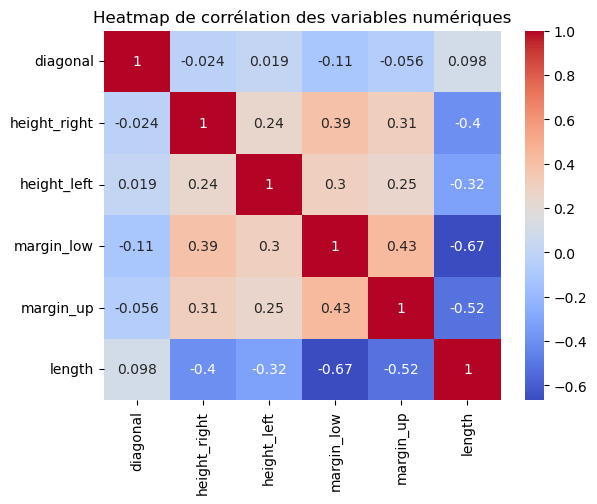

In [17]:
var_num = df_billet[['diagonal','height_right', 'height_left','margin_low', 'margin_up', 'length']]

corr = var_num.corr() 
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title('Heatmap de corrélation des variables numériques')
plt.show()

- Nous constatons qu'il n'y a une tres forte corelation entre les variables.
- Les variables qui sont un peu correlé length, margin_up et margin_low.

# Regression lineaire pour les valeurs manquantes

In [98]:
df_billet_sans_na = df_billet.dropna()

In [100]:
#entrainement du modèle à partir de toutes les variables
marge_basse = ols('margin_low ~ diagonal+height_left+height_right+margin_up+length', data=df_billet_sans_na).fit()
print(marge_basse.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Sat, 24 May 2025   Prob (F-statistic):          2.60e-202
Time:                        16:12:25   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

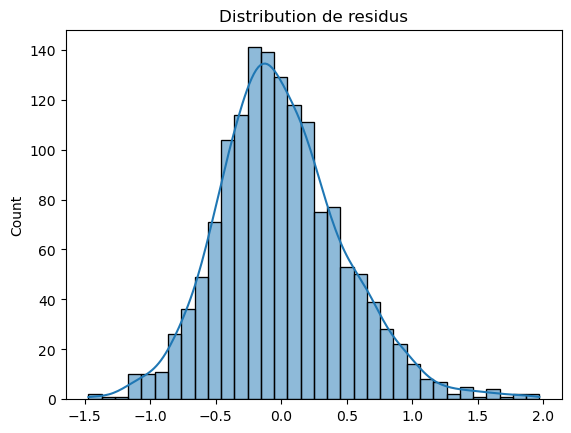

In [21]:
marge_basse.resid
sns.histplot(data=marge_basse.resid, kde=True)
plt.title('Distribution de residus')
plt.show()

- Les résidus sont plus centrés sur zéro (0), il a la forme d'une distribution normale mais nous allons vérifier la normalité avec des tests d'hypothèse.

#### Colinéarité des variables

In [24]:
variables = marge_basse.model.exog
vif = [variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]
for i, vif in enumerate(vif):
    print(f"Variable {i} - variance_inflation_factor : {vif:.2f}")

Variable 0 - variance_inflation_factor : 1.01
Variable 1 - variance_inflation_factor : 1.14
Variable 2 - variance_inflation_factor : 1.23
Variable 3 - variance_inflation_factor : 1.40
Variable 4 - variance_inflation_factor : 1.58


- Les coefficients sont inférieurs à 2, il n'y a pas de problème de colinéarité.

#### homoscédasticité,

In [27]:
_, pval, __, f_pval = het_breuschpagan(marge_basse.resid, marge_basse.model.exog)
print('p-value du test de Breusch-Pagan :', pval)

p-value du test de Breusch-Pagan : 7.759535216219784e-16


- Nous avons une homoscédasticité des résidus car le test de Breusch-Pagan donne une p-value > 0.05

Statistique de Shapiro-Wilk : 0.99
p-value : 0.0
Les résidus ne suivent pas une distribution normale.


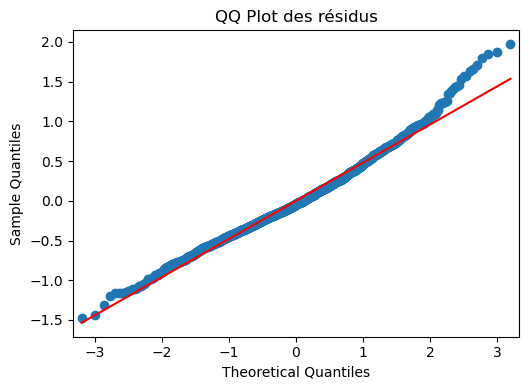

In [29]:
# test de shapiro ici sur les residus 
stat, p_value = shapiro(marge_basse.resid)
print("Statistique de Shapiro-Wilk :", round(stat, 2))
print("p-value :", round(p_value, 4))

if p_value < 0.05:
    print("Les résidus ne suivent pas une distribution normale.")
else:
    print("Les résidus suivent une distribution normale.")

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 2)
sm.qqplot(marge_basse.resid, line='s', ax=plt.gca())
plt.title("QQ Plot des résidus")

plt.tight_layout()
plt.show()

In [30]:
# Nous allons regrouper les valeurs dans un dataframe
df_valeurs_manq = df_billet[df_billet["margin_low"].isnull()]
df_valeurs_manq.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36


In [31]:
df_billet.dropna(inplace = True)

y_train = df_billet['margin_low']
X_train = df_billet.drop(['margin_low','is_genuine'], axis=1)
model_l = LinearRegression()
model_l.fit(X_train, y_train)

X_test = df_valeurs_manq.drop(['margin_low','is_genuine'], axis=1)

y_pred = model_l.predict(X_test)
model_l.score(X_train, y_train)

df_valeurs_manq.loc[df_valeurs_manq.margin_low.isnull(), 'margin_low'] = y_pred

In [32]:
df_merge = pd.concat([df_billet, df_valeurs_manq]).sort_index()
print('Ci dessous les informations du df_billet corrigé en df_merge')

df_merge.info()
df_merge.isnull().sum()

Ci dessous les informations du df_billet corrigé en df_merge
<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 83.5 KB


is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [33]:
df_merge.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


### Visualisation des variables margin_low et length :

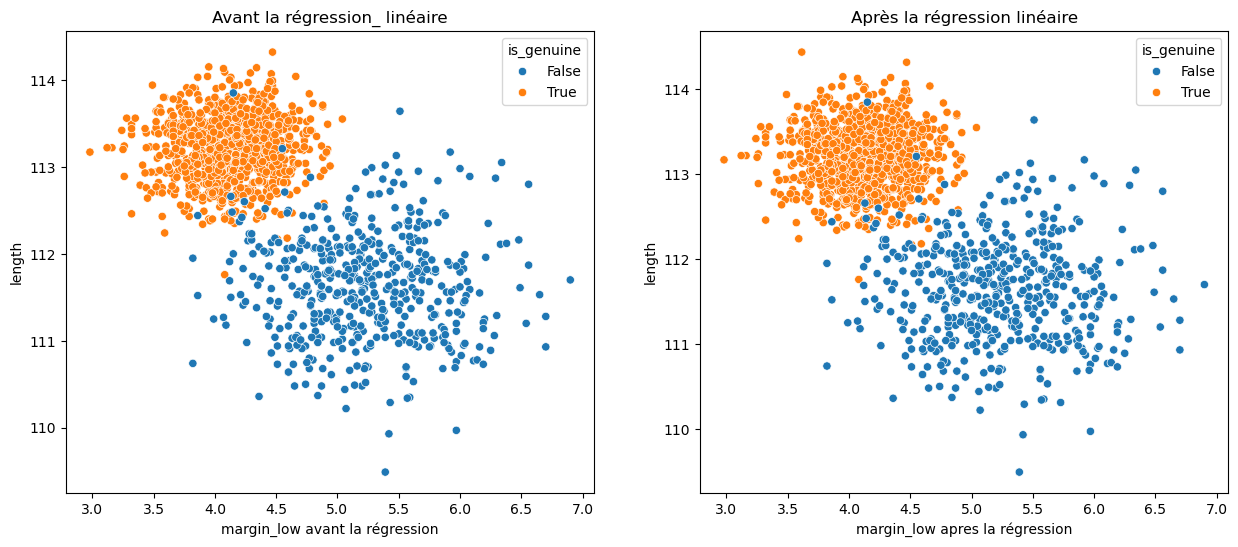

In [35]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sns.scatterplot(df_billet, x='margin_low', y='length', hue='is_genuine')
plt.xlabel('margin_low avant la régression')
plt.title('Avant la régression_ linéaire')

plt.subplot(1,2,2)
sns.scatterplot(df_merge, x='margin_low', y='length', hue='is_genuine')
plt.xlabel('margin_low apres la régression')
plt.title('Après la régression linéaire')

plt.show()

- Nous ne voyons pas d'impact visible sur les nuages de points avant et après la régression.

# Mise en place du K-means

In [38]:
colonnes_num = ['diagonal','height_right', 'height_left','margin_low', 'margin_up', 'length']
scaler = StandardScaler()
std_scaler = scaler.fit_transform(df_merge[colonnes_num])
df_scaler = pd.DataFrame(std_scaler, index=df_merge.index, columns=colonnes_num)

print("Ci dessous nous avons les données standardisées :")
df_scaler.head()

Ci dessous nous avons les données standardisées :


,diagonal,height_right,height_left,margin_low,margin_up,length
0,-0.486540,3.163240,2.774123,0.055390,-1.128325,0.173651
1,-1.633729,-0.799668,-2.236535,-1.081987,-0.696799,0.471666
2,2.397823,-1.291191,1.504756,-0.126591,-0.912562,0.551901
3,-1.961498,0.060498,-0.399294,-1.309463,-0.610494,0.953075
4,-0.748754,-1.414072,0.836669,-0.672532,1.417677,-0.158750


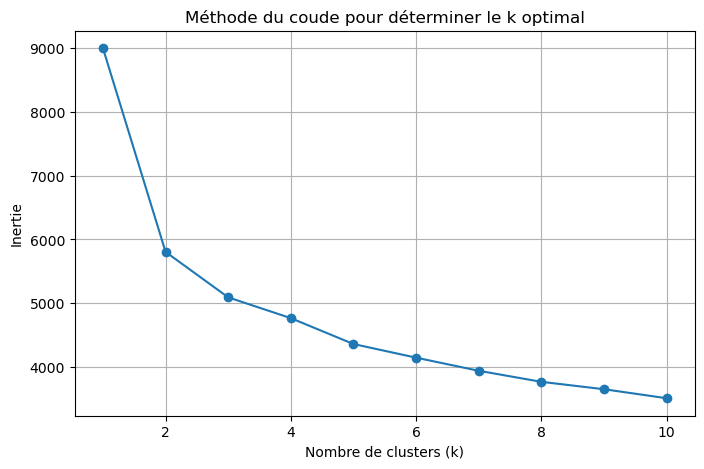

In [39]:
# Méthode du coude
inertias = []
K = range(1, 11)  # nombre de clusters à tester

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaler)
    inertias.append(kmeans.inertia_)

# Tracé de la courbe du coude
plt.figure(figsize=(8, 5))
plt.plot(K, inertias, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title("Méthode du coude pour déterminer le k optimal")
plt.grid(True)
plt.show()

In [40]:
n_clust = 2
X = df_scaler
km = KMeans(n_clusters=n_clust)
km.fit(X)
clusters = km.labels_

In [41]:
df_merge['cluster']= clusters

df_merge['is_genuine'].replace([True,False],[1,0],inplace =True)

### Nous allons faire une matrice de confusion pour évaluer la performance du modèle de classification

Matrice de confusion :


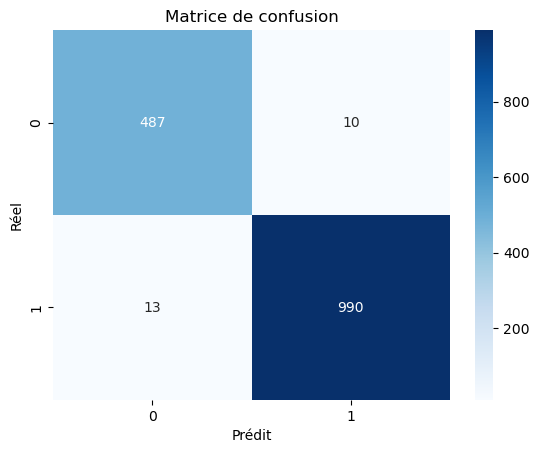


==> Le pourcentage d'accuracy pour le K-Mean 98.47 %


In [43]:
y_actu = df_merge['is_genuine']
y_pred = df_merge['cluster']

# Matrice de confusion
cm = confusion_matrix(y_pred,y_actu)
tn, fp, fn, tp = cm.ravel()  # extraction des 4 valeurs

# Affichage des résultats

print("Matrice de confusion :")

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()

# Calcul du pourcentage d'erreur
accuracy_km = np.round(accuracy_score(y_actu,y_pred)*100,2)
print(f"\n==> Le pourcentage d'accuracy pour le K-Mean {accuracy_km} %")

-- Matrice de confusion en pourcentage :
          Prédit: 0  Prédit: 1
- Réel: 0       99.0        1.0
- Réel: 1        2.6       97.4
- Réel: 0, Prédit: 0 -> 990 (66.0%)
- Réel: 0, Prédit: 1 -> 10 (0.7%)
- Réel: 1, Prédit: 0 -> 13 (0.9%)
- Réel: 1, Prédit: 1 -> 487 (32.5%)

# Mise en place de la régression logistique

In [46]:
X = df_merge.drop(columns=['is_genuine', 'cluster'])
y = df_merge['is_genuine']

# Encodage des variables catégorielles
X = pd.get_dummies(X, drop_first=True)

# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement du modèle
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)


=== Évaluation du modèle de régression logistique ===

Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       110
           1       0.98      1.00      0.99       190

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300

Matrice de confusion :


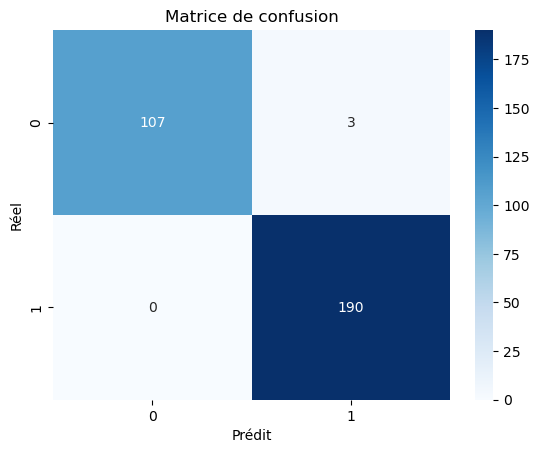


==> Le pourcentage d'accuracy pour la regression logistique 99.0 %


In [47]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()  # extraction des 4 valeurs

# Affichage des résultats
print("=== Évaluation du modèle de régression logistique ===\n")
print("Classification Report :")
print(classification_report(y_test, y_pred))

print("Matrice de confusion :")

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()

accuracy_rl = np.round(accuracy_score(y_test,y_pred)*100,2)
print(f"\n==> Le pourcentage d'accuracy pour la regression logistique {accuracy_rl} %")

# Mise en place du KNN (K-nearest neighbors)

In [51]:
# Entraîner le modèle KNN (choisir k = 5 par exemple)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Prédictions
y_pred = knn.predict(X_test)

print("Classification Report pour KNN :")
print(classification_report(y_test, y_pred))

print("Matrice de confusion pour KNN :")
print(confusion_matrix(y_test, y_pred))

Classification Report pour KNN :
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       110
           1       0.98      1.00      0.99       190

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300

Matrice de confusion pour KNN :
[[107   3]
 [  0 190]]


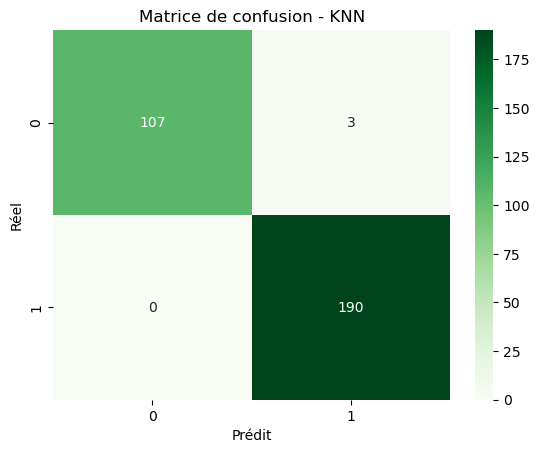


==> Le pourcentage d'accuracy pour le KNN 99.0 %


In [52]:
# visualisation de la matrice
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion - KNN')
plt.show()

accuracy_knn = np.round(accuracy_score(y_test,y_pred)*100,2)
print(f"\n==> Le pourcentage d'accuracy pour le KNN {accuracy_knn} %")

# Mise en place du Random Forest

In [76]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)


Évaluation du modèle Random Forest

Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       110
           1       0.98      1.00      0.99       190

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300

Matrice de confusion :


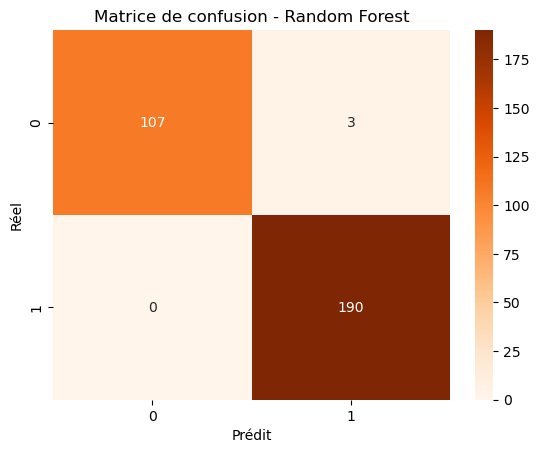


==> Le pourcentage d'accuracy pour le random forest 99.0 %


In [78]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Affichage des résultats
print("Évaluation du modèle Random Forest\n")
print("Classification Report :")
print(classification_report(y_test, y_pred))

print("Matrice de confusion :")

# Optionnel : visualisation de la matrice
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion - Random Forest')
plt.show()

accuracy_rf = np.round(accuracy_score(y_test,y_pred)*100,2)
print(f"\n==> Le pourcentage d'accuracy pour le random forest {accuracy_rf} %")

## Test de l’algorithme

In [81]:
import joblib
joblib.dump(model,'Mon_model.pkl')

['Mon_model.pkl']

In [83]:
Mon_model=joblib.load('Mon_model.pkl')

In [85]:
prediction = Mon_model.predict(X_test)
prediction

array([0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1], d

In [87]:
features = X_test.columns.tolist()
features

['diagonal',
 'height_left',
 'height_right',
 'margin_low',
 'margin_up',
 'length']

In [89]:
df_prod = pd.read_csv('billets_production.csv')
df_prod

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [91]:
def prediction_final(data):
    features=['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
    Mon_model=joblib.load('Mon_model.pkl')
    data['prediction']=Mon_model.predict(data[features])
    return data

In [93]:
prediction_final(df_prod)

,diagonal,height_left,height_right,margin_low,margin_up,length,id,prediction
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,1
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,1
